In [49]:
# Import packages
import scipy.io as sio
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from set_paths import data_path
import os
import seaborn as sns
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt
import plotly.io as pio

In [ ]:
### Load data ###

## Load data input to UMAP ##
struct_data = sio.loadmat(os.path.join(data_path, "umap_input_data.mat"))['mat']

# Initialize an empty list to store the field data
field_data_list = []
# Iterate over each field in the struct
for field_name in struct_data.dtype.names:
    # Extract the 2-dimensional array from each field
    field_data = struct_data[field_name][0]
    # Flatten the nested arrays
    field_data_flat = np.concatenate(field_data).ravel()
    # Append the flattened field data to the list
    field_data_list.append(field_data_flat)
# Create the DataFrame from the list of flattened field data
input_data = pd.DataFrame(field_data_list).transpose()
# Column names
colnames = ['age','global_efficiency','path_length', 'small_worldness','strength',
            'modularity', 'core/periphery', 'score', 'local_efficiency', 
            'clustering', 'betweenness', 'subgraph_centrality']
input_data.columns = colnames
ages = input_data['age']
# Group by age
grouped_input_data = input_data.groupby('age').mean().reset_index()

## Load PCA data ##

# Loadings
mat_file = sio.loadmat(os.path.join(data_path, "pca_rotated_loadings.mat"))
pca_loadings = np.array(mat_file['rotated_loadings'])
# Scores
mat_file = sio.loadmat(os.path.join(data_path, "pca_scores.mat"))
pca_scores = np.array(mat_file['score'])
# Cumulative variance
mat_file = sio.loadmat(os.path.join(data_path, "pca_cumvariance_explained.mat"))
pca_cumvar = np.array(mat_file['cumulative_variance_explained'])
# Eigenvalues
mat_file = sio.loadmat(os.path.join(data_path, "pca_eigenvalues.mat"))
pca_eigenvalues = np.array(mat_file['eigenvalues']).flatten()
# Parallel analysis eigenvalues
mat_file = sio.loadmat(os.path.join(data_path, "pca_simulated_eigenvalues.mat"))
pca_sim_eigenvalues = np.array(mat_file['simulated_eigenvalues']).flatten()

In [51]:
### Define variables ###

# Metrics
measures = ['Global Efficiency', 'Path Length', 'Small-Worldness','Strength',
                  'Modularity', 'Core/Periphery', 'S-Core', 'Local Efficiency', 
                  'Clustering Coefficient', 'Betweenness Centrality', 'Subgraph Centrality']
# Epochs
epoch_ranges = [
    (0,9),
    (9,32),
    (32,66),
    (66,83),
    (83,90)]

# Colors for epochs
line_colors = ['#FF5AAF','#008DF9','#FFC33B','#009F81','#A40122']

<positron-console-cell-12>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


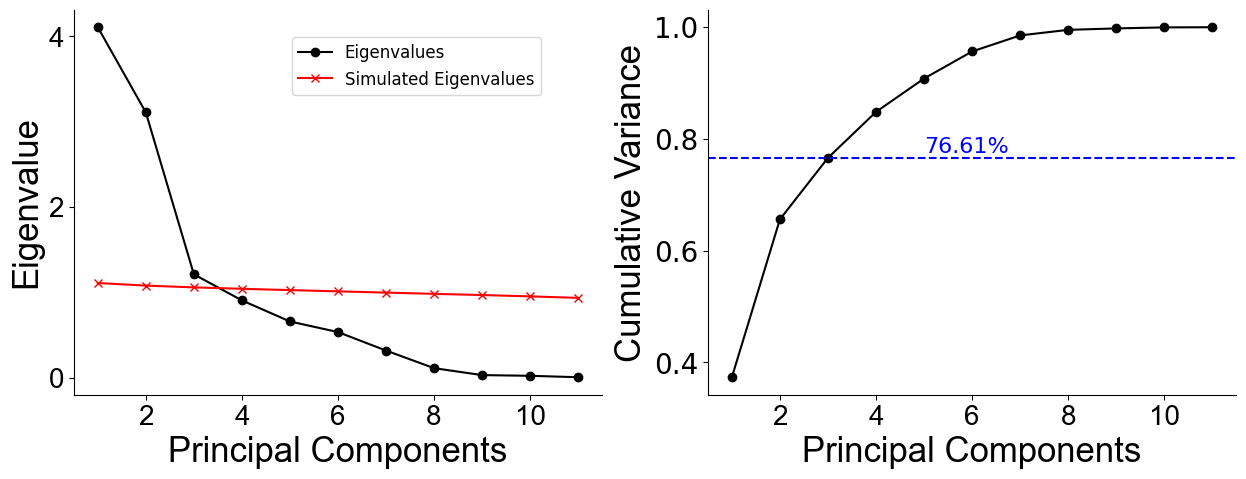

In [12]:
### Figure 5a ###

# Scree Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(pca_eigenvalues) + 1), pca_eigenvalues, 'ko-', label='Eigenvalues')
plt.plot(np.arange(1, len(pca_sim_eigenvalues) + 1), pca_sim_eigenvalues, 'rx-', label='Simulated Eigenvalues')
plt.xlabel('Principal Components',color='black',  family='Arial', fontsize=25)
plt.ylabel('Eigenvalue',family='Arial',color='black',fontsize=25)
plt.xticks([2,4,6,8,10],color='black',family='Arial',size=20)
plt.yticks([0,2,4],color='black',family='Arial',size=20)
plt.grid(False)
# Remove the box around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add Legend outside the graph on the top right
plt.legend(loc='upper right', bbox_to_anchor=(0.9, 0.95),fontsize=12)

# Cumulative Variance Explained Plot
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(pca_cumvar) + 1), pca_cumvar, 'ko-', label='Cumulative Variance')
plt.axhline(y=pca_cumvar[2], color='b', linestyle='--')
plt.annotate(f'{float(pca_cumvar[2])*100:.2f}%', xy=(5, pca_cumvar[2]), xytext=(5, pca_cumvar[2] + 0.01),
             fontsize=16,color='blue')
plt.xlabel('Principal Components',color='black', family='Arial', fontsize=25)
plt.ylabel('Cumulative Variance',color='black', family='Arial', fontsize=25)
plt.xticks([2,4,6,8,10],color='Black',family='Arial',fontsize=20)
plt.yticks([0.4,0.6,0.8,1.0],color='black',size=20)
plt.grid(False)
# Remove the box around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('pca_PCplots.png', bbox_inches='tight',dpi=500)
plt.show()

In [10]:
# Function to get the line color based on the index to identify integration, segregation and centrality metrics
# Define group colors
group_colors = ['#ee5038', '#00a78e', '#405eaa']

def get_line_color(index):
    if index < 4:
        return group_colors[0]
    elif 4 <= index <= 8:
        return group_colors[1]
    else:
        return group_colors[2]

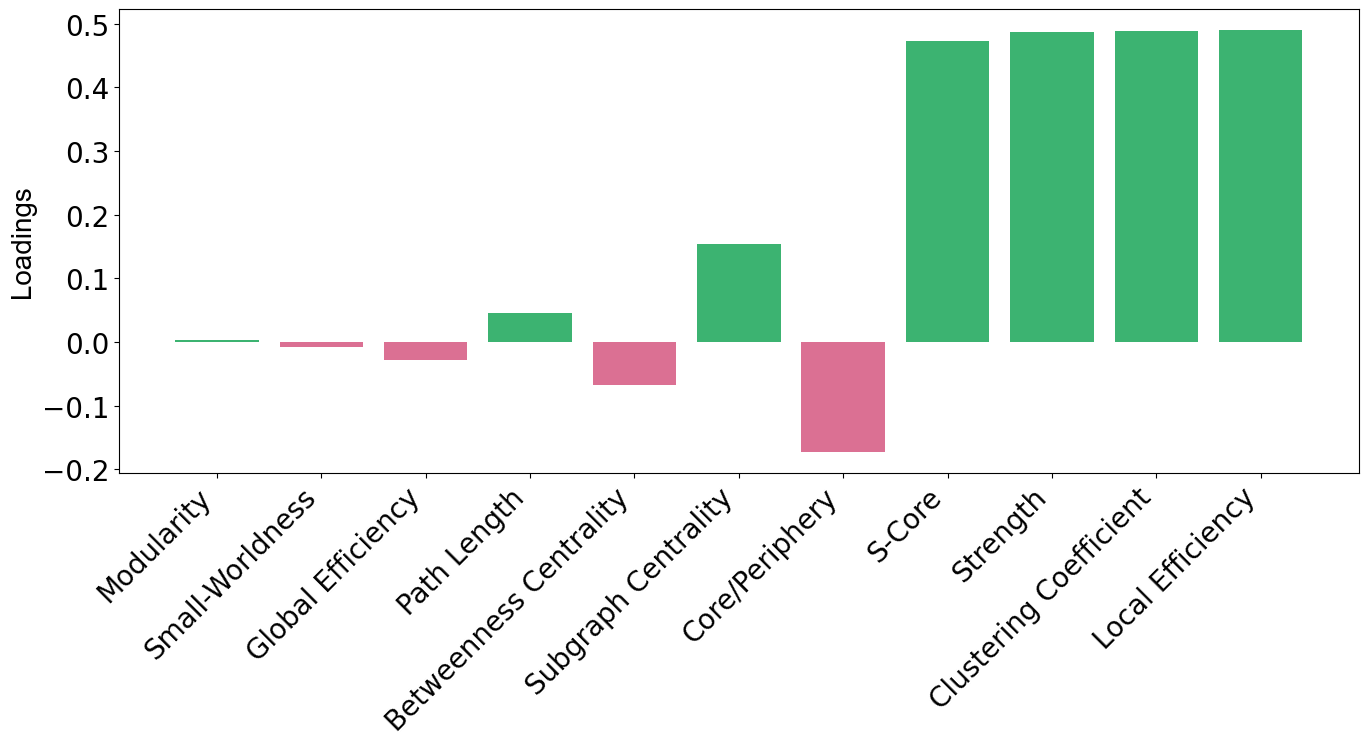

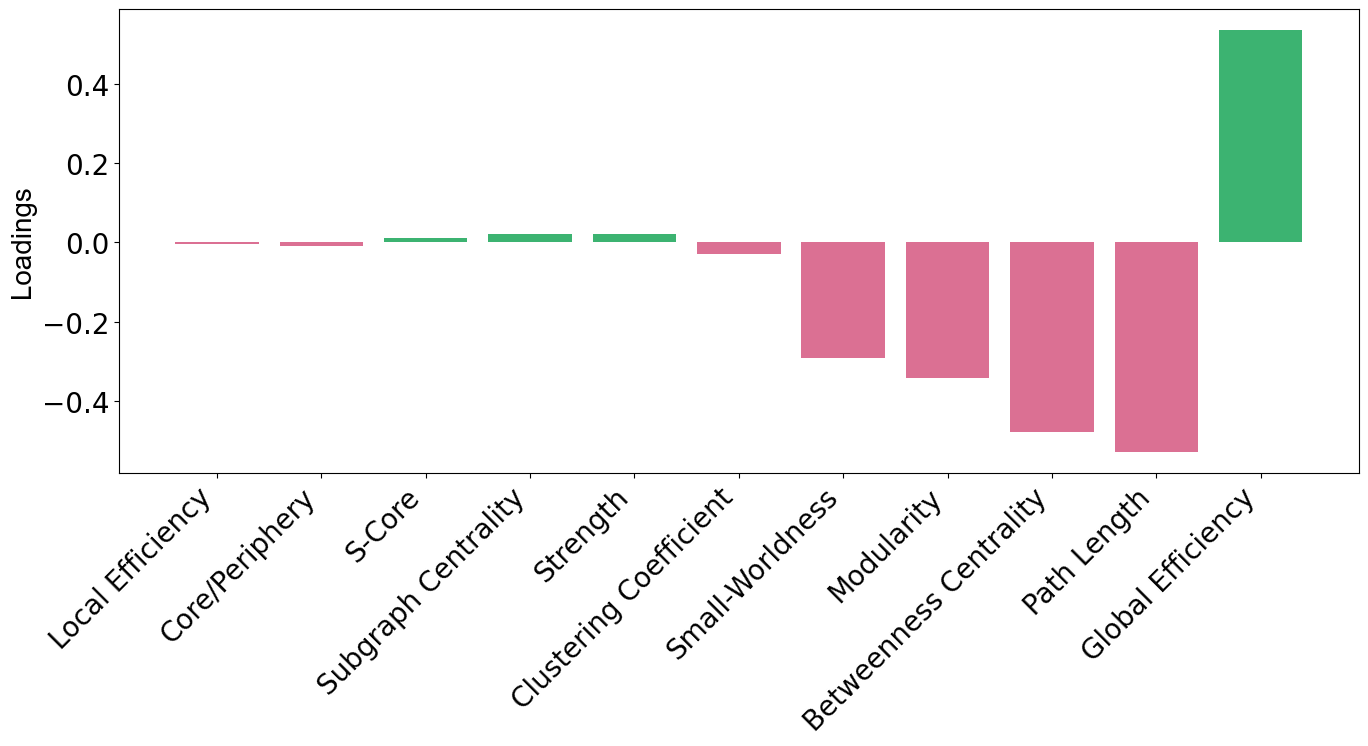

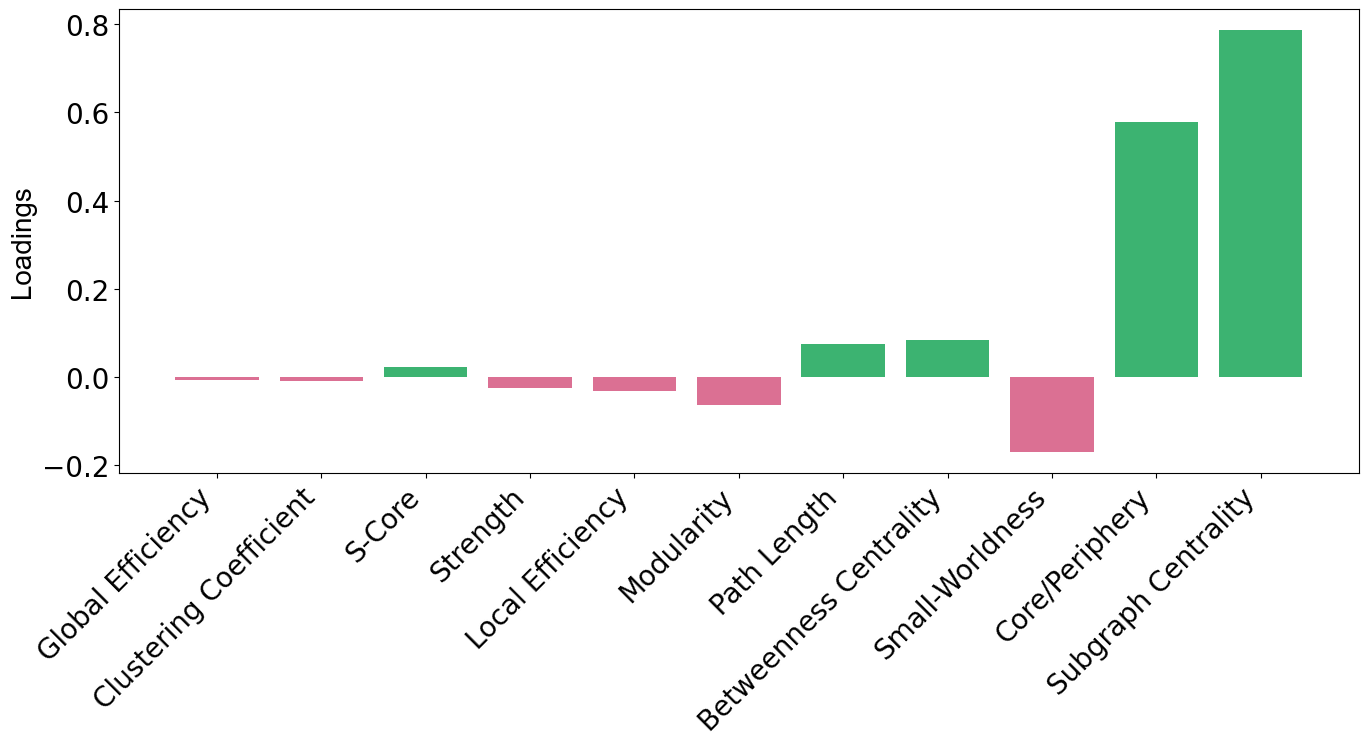

In [13]:
### Extended Data Figure 3b-d ###

# Loop through each PCA component
for i in range(3):
    # Get indices of the =loadings (positive or negative)
    top_indices = np.argsort(np.abs(pca_loadings[:, i])) 

    # Sort bars
    top_loadings = pca_loadings[top_indices, i]
    top_predictors = [measures[idx] for idx in top_indices]

    # Create a bar plot
    plt.figure(figsize=(16,8))
    plt.bar(top_predictors, top_loadings, color=np.where(top_loadings >= 0, 'mediumseagreen', 'palevioletred'))

    # Set plot title and labels
    plt.ylabel('Loadings', color='black', family='Arial', fontsize=20)
    plt.tick_params(axis='x', labelsize=20,color='black')  
    plt.xticks(rotation=45, ha='right')  
    plt.tick_params(axis='y', labelsize=20,color='black')
    plt.subplots_adjust(bottom=0.3)

    # Plot
    plt.savefig(f'pca_PC{i+1}_plot.png', bbox_inches='tight', dpi=500)
    plt.show()

In [52]:
### Figure 5a ###

# Standarize the scores
std_scores = pca_scores / np.std(pca_scores, axis=0)
std_loadings = pca_loadings * np.max(np.abs(pca_scores))


# Make abbreviations (note: these abbreviations were replaced with full labels in the figure)
predabb = ['GE', 'PL', 'SW','Str','Mod', 'C/P', 'SC', 'LE', 'CC', 'BC', 'SC']

# Create a 3D biplot
fig = go.Figure()

# Plot PCA loadings as lines
for i in range(len(measures)):
    text_position = 'middle right'  # Default text position

    # Change text position fo SC and CC for better visualization
    if predabb[i] == 'SC':
        text_position = 'top right'
    elif predabb[i] == 'CC':
        text_position = 'bottom right'

        
    fig.add_trace(go.Scatter3d(
        x=[0, pca_loadings[i, 0]],
        y=[0, pca_loadings[i, 1]],
        z=[0, pca_loadings[i, 2]],
        mode='lines+text',
        line=dict(color=get_line_color(i), width=8),
        showlegend=False,
        # Comment out these 6 lines to remove abberviations
        #text=[None, predabb[i]],
        #textposition=text_position,    
        #textfont=dict(
            #family="Arial, sans-serif",
            #size=16,
          #color='black')
    ))
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='',
            linecolor='black',
            tickcolor='black',
            linewidth=10,
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black', size=13), 
            #titlefont=dict(color='black', size=30, family='Arial'),
            range = [-0.65,0.65],
            tickvals=[-0.5, 0, 0.5]
        ),
        yaxis=dict(
            title='',
            linecolor='black',
            tickcolor='black',
            linewidth=10,
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black', size=13), 
            #titlefont=dict(color='black', size=30, family='Arial'),
            tickvals=[-0.4,0,0.4]
        ),
        zaxis=dict(
            title='',
            linecolor='black',
            tickcolor='black',
            linewidth=10,
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black', size=13), 
            #titlefont=dict(color='black', size=30, family='Arial'),
            tickvals=[0,0.4,0.8]
        )
    ),
    scene_camera=dict(
        eye=dict(x=4, y=2, z=2) 
    )
)

pio.write_image(fig, 'PCA_3d.png', width=800, height=900,scale=3)  

# Show the plot
fig.show()

In [54]:
### Extended Data Figure 3e ###

# Create a DataFrame with standardized scores and age
df_scores = pd.DataFrame(pca_scores, columns=['PC1', 'PC2', 'PC3'])
df_scores['Age'] = input_data['age']
df_avg_scores = df_scores.groupby('Age').mean().reset_index()

# Create a 3D biplot
fig = go.Figure()
# Plot PCA loadings as arrows and label predictors with different colors
for i in range(len(measures)):
    # Define custom legend names
    legend_name = 'Integration' if i == 0 else ('Segregation' if i == 6 else ('Centrality' if i == 10 else predabb[i]))

    fig.add_trace(go.Scatter3d(
        x=[0, pca_loadings[i, 0]*15],
        y=[0, pca_loadings[i, 1]*15],
        z=[0, pca_loadings[i, 2]*15],
        mode='lines',
        line=dict(color=get_line_color(i), width=6)
    ))

# Scatter plot of PCA scores colored by 'age'
fig.add_trace(go.Scatter3d(
    x=df_avg_scores['PC1'],
    y=df_avg_scores['PC2'],
    z=df_avg_scores['PC3'],
    mode='markers',
    marker=dict(
        size=10,
        color=df_avg_scores['Age'],
        colorscale='inferno',
        opacity=0.8,
        colorbar=dict(title='Age')
    ), showlegend= False
))

fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='PC1',
            linecolor='black',
            tickcolor='black',
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black'),
            #titlefont=dict(color='black', size=10, family='Arial')
        ),
        yaxis=dict(
            title='PC2',
            linecolor='black',
            tickcolor='black',
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black'),
            #titlefont=dict(color='black', size=10, family='Arial')
        ),
        zaxis=dict(
            title='PC3',
            linecolor='black',
            tickcolor='black',
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black'),
            #titlefont=dict(color='black', size=10, family='Arial')
        )
    ),
    scene_camera=dict(
        eye=dict(x=4, y=2, z=2) 
    )
)
# Show the plot
pio.write_image(fig, 'PCA_biplot.png', width=800, height=900,scale=3)  
fig.show()

In [18]:
# Select PCA scores based on epochs
pca_scores = pd.DataFrame(pca_scores, columns=['PC1', 'PC2', 'PC3'])
epoch_data1 = pca_scores[(input_data['age'] >= epoch_ranges[0][0]) & (input_data['age'] <= epoch_ranges[0][1])]
epoch_data2 = pca_scores[(input_data['age'] >= epoch_ranges[1][0]) & (input_data['age'] <= epoch_ranges[1][1])]
epoch_data3 = pca_scores[(input_data['age'] >= epoch_ranges[2][0]) & (input_data['age'] <= epoch_ranges[2][1])]
epoch_data4 = pca_scores[(input_data['age'] >= epoch_ranges[3][0]) & (input_data['age'] <= epoch_ranges[3][1])]
epoch_data5 = pca_scores[(input_data['age'] >= epoch_ranges[4][0]) & (input_data['age'] <= epoch_ranges[4][1])]

# Get PCA socre averages per epoch
averages = pd.DataFrame({'PC1': [np.mean(epoch_data1['PC1']),np.mean(epoch_data2['PC1']),np.mean(epoch_data3['PC1']),np.mean(epoch_data4['PC1']),np.mean(epoch_data5['PC1'])],
                         'PC2': [np.mean(epoch_data1['PC2']),np.mean(epoch_data2['PC2']),np.mean(epoch_data3['PC2']),np.mean(epoch_data4['PC2']),np.mean(epoch_data5['PC2'])],
                         'PC3': [np.mean(epoch_data1['PC3']),np.mean(epoch_data2['PC3']),np.mean(epoch_data3['PC3']),np.mean(epoch_data4['PC3']),np.mean(epoch_data5['PC3'])]})

averages

,PC1,PC2,PC3
0,-0.778742,-0.383354,-0.147824
1,-0.513992,0.068516,-0.098417
2,0.573794,0.371730,-0.063772
3,1.648150,-0.518713,0.559694
4,1.849713,-1.200269,0.897375


In [48]:
### Figure 5a ###

labels = ['Epoch: 0-9', 'Epoch: 9-33', 'Epoch: 33-65', 'Epoch: 65-83', 'Epoch: 83-90']

# Create a 3D scatter plot with separate traces for each epoch
fig = go.Figure()

for i in range(len(averages)):
    fig.add_trace(go.Scatter3d(
        x=[averages.loc[i, 'PC1']],
        y=[averages.loc[i, 'PC2']],
        z=[averages.loc[i, 'PC3']],
        mode='markers',
        marker=dict(size=25, color=line_colors[i]),
        name=labels[i]
    ))

# Update layout to show legend
fig.update_layout(showlegend=False)
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='',
            linecolor='black',
            tickcolor='black',
            linewidth=20,
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black', size=10),  
            #titlefont=dict(color='black', size=30, family='Arial'),
            range=[-2, 2],
            tickvals=[ -1, 0, 1],
            tickwidth=2,  
            ticklen=10  
        ),
        yaxis=dict(
            title='',
            linecolor='black',
            tickcolor='black',
            linewidth=20,
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black', size=10),  
            #titlefont=dict(color='black', size=30, family='Arial'),
            range=[-2, 2],
            tickvals=[-2, 0, 2],
        ),
        zaxis=dict(
            title='',
            linecolor='black',
            tickcolor='black',
            linewidth=20,
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black', size=10),  
            #titlefont=dict(color='black', size=30, family='Arial'),
            range=[-1, 4],
            tickvals=[0, 2, 4],
        ),
        camera=dict(
            eye=dict(x=-0.5, y=2, z=1)  
        ),
        aspectmode='manual',
        aspectratio=dict(x=1.5, y=0.5, z=1)
    )
)
pio.write_image(fig, 'PCA_epochs_perspective1.png', width=900, height=800,scale=3) 

# Show the plot
fig.show()

<positron-console-cell-20>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




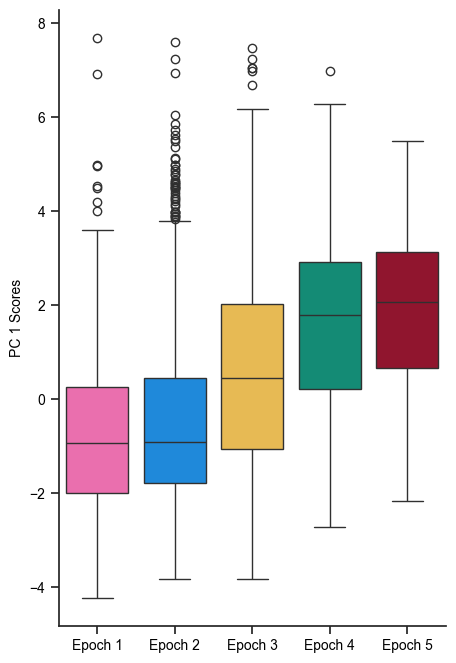

<positron-console-cell-20>:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




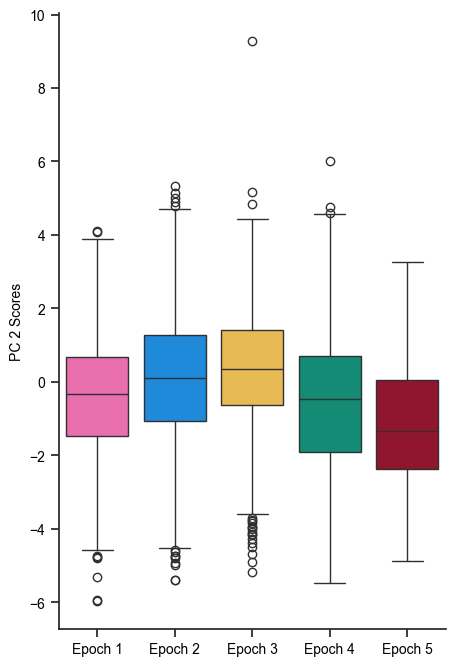

<positron-console-cell-20>:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




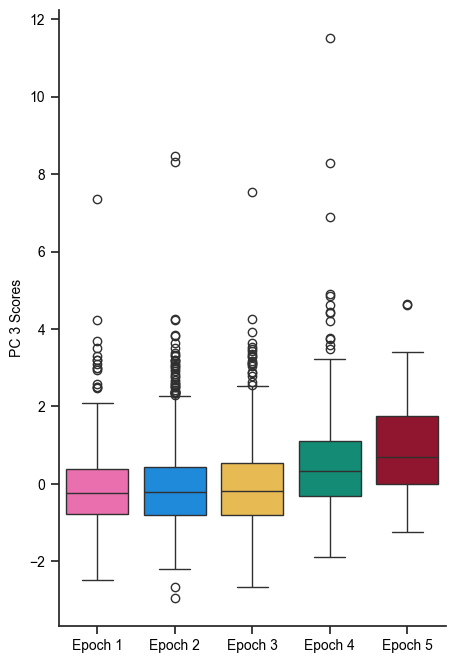

In [20]:
### Extended Data Figure 4b ###

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

## PC1 ##
plt.figure(figsize=(5, 8))
sns.boxplot(x='Epoch', y='PC1', data=pd.concat([epoch_data1.assign(Epoch='Epoch 1'),
                                                epoch_data2.assign(Epoch='Epoch 2'),
                                                epoch_data3.assign(Epoch='Epoch 3'),
                                                epoch_data4.assign(Epoch='Epoch 4'),
                                                epoch_data5.assign(Epoch='Epoch 5')]),
            palette=line_colors)
plt.ylabel('PC 1 Scores',color='black', family='Arial', fontsize=10)
plt.yticks(color='black',family='Arial',size=10)
plt.xticks(color='black',family='Arial',size=10)
plt.xlabel('')
plt.savefig('PC1_boxplot.png', bbox_inches='tight', dpi=500)
plt.show()

## PC 2 ##
plt.figure(figsize=(5, 8))
sns.boxplot(x='Epoch', y='PC2', data=pd.concat([epoch_data1.assign(Epoch='Epoch 1'),
                                                epoch_data2.assign(Epoch='Epoch 2'),
                                                epoch_data3.assign(Epoch='Epoch 3'),
                                                epoch_data4.assign(Epoch='Epoch 4'),
                                                epoch_data5.assign(Epoch='Epoch 5')]),
            palette=line_colors)
plt.ylabel('PC 2 Scores',color='black', family='Arial', fontsize=10)
plt.yticks(color='black',family='Arial',size=10)
plt.xticks(color='black',family='Arial',size=10)
plt.xlabel('')
plt.savefig('PC2_boxplot.png', bbox_inches='tight', dpi=500)
plt.show()

## PC 3 ##
plt.figure(figsize=(5, 8))
sns.boxplot(x='Epoch', y='PC3', data=pd.concat([epoch_data1.assign(Epoch='Epoch 1'),
                                                epoch_data2.assign(Epoch='Epoch 2'),
                                                epoch_data3.assign(Epoch='Epoch 3'),
                                                epoch_data4.assign(Epoch='Epoch 4'),
                                                epoch_data5.assign(Epoch='Epoch 5')]),
            palette=line_colors)
plt.ylabel('PC 3 Scores',color='black', family='Arial', fontsize=10)
plt.yticks(color='black',family='Arial',size=10)
plt.xticks(color='black',family='Arial',size=10)
plt.xlabel('')
plt.savefig('PC3_boxplot.png', bbox_inches='tight', dpi=500)
plt.show()

In [21]:
### PC 1 statistics ###

# Pull PC 1
pc_1 = [epoch_data1['PC1'], epoch_data2['PC1'], epoch_data3['PC1'], epoch_data4['PC1'], epoch_data5['PC1']]
alpha = 0.05 # P-value cut-off

# Perform Levene's test for homogeneity of variance
statistic, p_value_levene = stats.levene(*pc_1)
print("Levene's test statistic:", statistic)
print("Levene's test p-value:", p_value_levene)

# Check if there is a significant difference in variation
if p_value_levene < alpha:
    print("Levene's test is significant")

    # Calculate variance for each epoch
    variances = [np.var(data) for data in pc_1]
    print("Variances per epoch:")
    for i, var in enumerate(variances):
        print(f"Epoch {i+1}: {var}")
else:
    print("Levene's test is not significant")

## Because of significant Levene's, run Welch's ANOVA (does not assume equal variances)  ##

# Concatenate the data with group labels
data = pd.concat(pc_1, keys=['group1', 'group2', 'group3', 'group4', 'group5'], names=['group', 'index']).reset_index()
grouped_data = data.groupby('group').agg({'PC1': ['mean', 'std']})
# Flatten the multi-level columns
grouped_data.columns = ['mean', 'std']
# Display the result
print(grouped_data)

# Perform Welch's ANOVA
wanova = pg.welch_anova(dv='PC1', between='group', data=data)
print(wanova)
# Pariwise Gameshowell to tes group specific differences
group_diff = pg.pairwise_gameshowell(dv='PC1', between='group', data=data,effsize='cohen')
group_diff

Levene's test statistic: 15.049066398813777
Levene's test p-value: 3.2459191012942475e-12
Levene's test is significant
Variances per epoch:
Epoch 1: 3.04015677825998
Epoch 2: 3.1376332241112674
Epoch 3: 4.025620861645084
Epoch 4: 3.5658666875404412
Epoch 5: 3.1946908075366682
            mean       std
group                     
group1 -0.778742  1.744795
group2 -0.513992  1.771849
group3  0.573794  2.007314
group4  1.648150  1.890680
group5  1.849713  1.797058
  Source  ddof1       ddof2           F          p-unc       np2
0  group      4  572.351774  195.095082  2.087861e-105  0.162791


,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,group1,group2,-0.778742,-0.513992,-0.264750,0.077266,-3.426473,1399.023485,5.673499e-03,-0.150099
1,group1,group3,-0.778742,0.573794,-1.352536,0.088561,-15.272350,1706.633466,0.000000e+00,-0.709526
2,group1,group4,-0.778742,1.648150,-2.426893,0.113832,-21.319864,781.046723,6.247225e-13,-1.349686
3,group1,group5,-0.778742,1.849713,-2.628455,0.197175,-13.330547,115.116137,3.619327e-14,-1.501367
4,group2,group3,-0.513992,0.573794,-1.087786,0.074207,-14.658836,2107.153392,1.133982e-12,-0.582783
5,group2,group4,-0.513992,1.648150,-2.162143,0.103060,-20.979400,583.559312,1.618705e-13,-1.204518
6,group2,group5,-0.513992,1.849713,-2.363706,0.191159,-12.365137,101.863890,3.153033e-14,-1.333067
7,group3,group4,0.573794,1.648150,-1.074357,0.111779,-9.611471,765.666378,1.998401e-15,-0.543588
8,group3,group5,0.573794,1.849713,-1.275920,0.195997,-6.509900,112.483396,2.167568e-08,-0.640599
9,group4,group5,1.648150,1.849713,-0.201563,0.208637,-0.966092,142.487511,8.698967e-01,-0.107575


In [ ]:
### PC 2 statistics ###

pc_2 = [epoch_data1['PC2'], epoch_data2['PC2'], epoch_data3['PC2'], epoch_data4['PC2'], epoch_data5['PC2']]
alpha = 0.05
# Perform Levene's test for homogeneity of variance
statistic, p_value_levene = stats.levene(*pc_2)
print("Levene's test statistic:", statistic)
print("Levene's test p-value:", p_value_levene)

# Check if there is a significant difference in variation
if p_value_levene < alpha:
    print("Levene's test is significant")

    # Calculate variance for each epoch
    variances = [np.var(data) for data in pc_2]
    print("Variances per epoch:")
    for i, var in enumerate(variances):
        print(f"Epoch {i+1}: {var}")
else:
    print("Levene's test is not significant")

## Because of significant Levene's, run Welch's ANOVA (does not assume equal variances) ##

# Concatenate the data with group labels
data = pd.concat(pc_2, keys=['group1', 'group2', 'group3', 'group4', 'group5'], names=['group', 'index']).reset_index()
# Group by the 'group' level and calculate the mean for each group
group_means = data.groupby('group').mean()


grouped_data = data.groupby('group').agg({'PC2': ['mean', 'std']})
# Flatten the multi-level columns
grouped_data.columns = ['mean', 'std']
# Display the result
print(grouped_data)

# Perform Welch's ANOVA
wanova = pg.welch_anova(dv='PC2', between='group', data=data)
print(wanova)
# Pariwise Gameshowell to tes group specific differences
group_diff = pg.pairwise_gameshowell(dv='PC2', between='group', data=data,effsize='cohen')
group_diff

Levene's test statistic: 4.826295924279328
Levene's test p-value: 0.0006974329733081277
Levene's test is significant
Variances per epoch:
Epoch 1: 2.570285226772313
Epoch 2: 3.081018533504342
Epoch 3: 2.8934152569062617
Epoch 4: 3.721300342999506
Epoch 5: 3.394372900263059
            mean       std
group                     
group1 -0.383354  1.604306
group2  0.103500  1.755765
group3  0.357491  1.701886
group4 -0.475394  1.931309
group5 -1.200269  1.852368
  Source  ddof1       ddof2          F         p-unc       np2
0  group      4  571.570912  38.793817  9.583061e-29  0.037915


,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,group1,group2,-0.383354,0.103500,-0.486854,0.072146,-6.748130,1470.812005,2.146491e-10,-0.284099
1,group1,group3,-0.383354,0.357491,-0.740845,0.080702,-9.180028,1619.649390,0.000000e+00,-0.446165
2,group1,group4,-0.383354,-0.475394,0.092040,0.110297,0.834468,774.794861,9.198707e-01,0.053125
3,group1,group5,-0.383354,-1.200269,0.816915,0.201014,4.063968,110.219018,8.489321e-04,0.499988
4,group2,group3,0.103500,0.357491,-0.253991,0.068522,-3.706710,2018.367444,2.010430e-03,-0.146200
5,group2,group4,0.103500,-0.475394,0.578894,0.101725,5.690767,609.273778,1.959897e-07,0.323285
6,group2,group5,0.103500,-1.200269,1.303769,0.196441,6.636942,100.630270,1.633485e-08,0.740552
7,group3,group4,0.357491,-0.475394,0.832885,0.107961,7.714656,740.271533,2.468026e-13,0.469014
8,group3,group5,0.357491,-1.200269,1.557760,0.199742,7.798865,107.509504,4.280942e-11,0.908039
9,group4,group5,-0.475394,-1.200269,0.724875,0.213423,3.396420,138.589412,7.817677e-03,0.378006


In [ ]:
### PC 3 statistics ###
pc_3 = [epoch_data1['PC3'], epoch_data2['PC3'], epoch_data3['PC3'], epoch_data4['PC3'], epoch_data5['PC3']]
alpha = 0.05
# Perform Levene's test for homogeneity of variance
statistic, p_value_levene = stats.levene(*pc_3)
print("Levene's test statistic:", statistic)
print("Levene's test p-value:", p_value_levene)


# Check if there is a significant difference in variation
if p_value_levene < alpha:
    print("Levene's test is significant")

    # Calculate variance for each epoch
    variances = [np.var(data) for data in pc_3]
    print("Variances per epoch:")
    for i, var in enumerate(variances):
        print(f"Epoch {i+1}: {var}")
else:
    print("Levene's test is not significant")

## Because of significant Levene's, run Welch's ANOVA (does not assume equal variances) ##

# Concatenate the data with group labels
data = pd.concat(pc_3, keys=['epoch1', 'epoch2', 'epoch3', 'epoch4', 'epoch5'], names=['epoch', 'index']).reset_index()
grouped_data = data.groupby('epoch').agg({'PC3': ['mean', 'std']})
# Flatten the multi-level columns
grouped_data.columns = ['mean', 'std']
# Display the result
print(grouped_data)

# Perform Welch's ANOVA
wanova = pg.welch_anova(dv='PC3', between='epoch', data=data)
print(wanova)
# Pariwise Gameshowell to tes group specific differences
group_diff = pg.pairwise_gameshowell(dv='PC3', between='epoch', data=data,effsize='cohen')
group_diff

Levene's test statistic: 9.247894573467613
Levene's test p-value: 1.9504869918873438e-07
Levene's test is significant
Variances per epoch:
Epoch 1: 0.928556564197052
Epoch 2: 1.079456455802293
Epoch 3: 1.145477029009085
Epoch 4: 1.908589282742285
Epoch 5: 1.4403612968011161
            mean       std
epoch                     
epoch1 -0.147824  0.964274
epoch2 -0.091804  1.039254
epoch3 -0.065780  1.070825
epoch4  0.520182  1.383123
epoch5  0.897375  1.206655
  Source  ddof1       ddof2          F         p-unc       np2
0  epoch      4  566.137816  35.138803  3.134529e-26  0.045968


,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,epoch1,epoch2,-0.147824,-0.091804,-0.056020,0.043150,-1.298248,1449.430755,6.923582e-01,-0.055013
1,epoch1,epoch3,-0.147824,-0.065780,-0.082044,0.049566,-1.655262,1647.776909,4.622239e-01,-0.079950
2,epoch1,epoch4,-0.147824,0.520182,-0.668006,0.075545,-8.842451,678.356750,2.727818e-13,-0.587314
3,epoch1,epoch5,-0.147824,0.897375,-1.045199,0.130095,-8.034146,107.423750,1.308531e-11,-1.051222
4,epoch2,epoch3,-0.091804,-0.065780,-0.026025,0.042210,-0.616551,1914.281050,9.724959e-01,-0.024778
5,epoch2,epoch4,-0.091804,0.520182,-0.611986,0.070937,-8.627217,550.342097,5.302425e-13,-0.549732
6,epoch2,epoch5,-0.091804,0.897375,-0.989180,0.127474,-7.759875,99.099375,7.764700e-11,-0.943940
7,epoch3,epoch4,-0.065780,0.520182,-0.585962,0.075012,-7.811548,669.641193,1.816325e-13,-0.498251
8,epoch3,epoch5,-0.065780,0.897375,-0.963155,0.129786,-7.421112,106.436526,2.983075e-10,-0.889064
9,epoch4,epoch5,0.520182,0.897375,-0.377193,0.141756,-2.660869,148.997149,6.484736e-02,-0.278641
